## Import libs and explore the tokens list

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm_notebook
from collections import Counter

In [2]:
with open('../out/tokens_post.txt', 'rb') as fp:   #Pickling
    tokens_post = pickle.load(fp)

In [3]:
# check token length distribution
tkn_len = [len(x) for x in tokens_post]

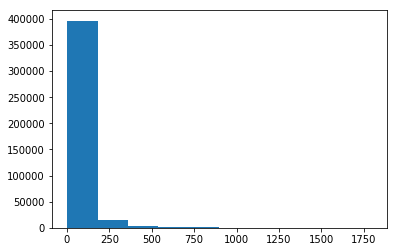

In [4]:
_=plt.hist(tkn_len)

In [5]:
np.median(tkn_len)

34.0

## Create a flat list of tokens and filter only vocabs that account for 95% of total words

In [6]:
tokens_all = [tkn for tkn_lst in tokens_post for tkn in tkn_lst]

In [7]:
print(0.05*len(tokens_all))

1192319.95


In [8]:
# filter out vocab with low frequency
tkn_counter = Counter(tokens_all)

tkn_counter = tkn_counter.most_common()

tkn_counter = sorted(tkn_counter,key=lambda x:x[1])

accum_freq = 0
ws_out = []
for w,freq in tkn_counter:
    ws_out.append(w)
    accum_freq+=freq
    if accum_freq > 1192319:
        break

print('words to delete:',len(ws_out))

print('total words:',len(tkn_counter))

# to keep
print('kept words:',len(tkn_counter) - len(ws_out))

words to delete: 249894
total words: 261410
kept words: 11516


In [9]:
tkn_counter = Counter(tokens_all)
tkn_counter = tkn_counter.most_common(10000)

vocab,_ = zip(*tkn_counter)

word_to_ix = {word: i for i, word in enumerate(vocab)}

ix_to_word = {ix:word for word,ix in word_to_ix.items()}

In [10]:
tokens_95 = []
for tkn in tqdm_notebook(tokens_all):
    if tkn in vocab:
        tokens_95.append(tkn)

In [13]:
with open('../out/tokens_95.pkl', 'wb') as fp:   #Pickling
    pickle.dump(tokens_95,fp)

In [14]:
with open('../out/tokens_95.pkl', 'rb') as fp:   #Pickling
    tokens_95 = pickle.load(fp)

# Modelling

## Dataset & DataLoader

In [15]:
#torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class CBOWDataset(Dataset):
    def __init__(self, tkns_list, context_sz, w2idx):
        self.tkns_list = tkns_list
        self.context_sz = context_sz
        
        context_list = []
        target_list = []
        for i in range(context_sz, len(tkns_list)-context_sz):
            context = []
            for j in range(context_sz,0,-1):
                context.append(w2idx[tkns_list[i-j]])
            for j in range(1,context_sz+1):
                context.append(w2idx[tkns_list[i+j]])
            context_list.append(context)
            target_list.append(w2idx[tkns_list[i]])
        self.context = context_list
        self.target = target_list
        
    def __getitem__(self, index):
        return(torch.tensor(self.context[index], dtype=torch.long, device=device),
       torch.tensor(self.target[index], dtype=torch.long, device=device))
    
    def __len__(self):
        return len(self.target)

cuda:0


In [17]:
CONTEXT_SIZE = 5
cbow_ds = CBOWDataset(tokens_95, CONTEXT_SIZE, word_to_ix)

In [18]:
cbow_ds[0]

(tensor([  42, 1527, 2307,  291, 5499, 1527, 2307,  291, 5499, 3194],
        device='cuda:0'), tensor(42, device='cuda:0'))

In [24]:
rand_indx = np.random.randint(0,len(cbow_ds))

In [37]:
# test the dataset output validity
rand_indx = np.random.randint(0,len(cbow_ds))
[ix_to_word[ix] for ix in cbow_ds[rand_indx][0].cpu().numpy()]

['ค่าปรับ',
 'ทางด่วน',
 'บูรพา',
 'วิถี',
 'โดน',
 'ด่าน',
 'ตรวจจับ',
 'ความเร็ว',
 'บูรพา',
 'วิถี']

In [38]:
ix_to_word[cbow_ds[rand_indx][1].cpu().numpy().item()]

'ใบสั่ง'

In [80]:
bs = 2**15
cbow_dl = DataLoader(cbow_ds, batch_size=bs, shuffle=False)

In [81]:
print(next(iter(cbow_dl))[0].shape)
print(next(iter(cbow_dl))[1].shape)

torch.Size([32768, 10])
torch.Size([32768])


## Model

In [82]:
class CBOW(nn.Module):
    
    def __init__(self, config):
        super(CBOW,self).__init__()
        self.embeddings = nn.Embedding(config['vocab_size'], config['embedding_dim'])
        self.linear1 = nn.Linear(config['embedding_dim'], config['fc_size'])
        self.linear2 = nn.Linear(config['fc_size'],config['vocab_size'])
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs).sum(dim=1)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        
        return log_probs

In [83]:
config = {'vocab_size':11000,
         'embedding_dim':500,
         'fc_size':1024}
cbow_model = CBOW(config).to(device)
x = next(iter(cbow_dl))
ins = x[0]
cbow_model(ins).shape

torch.Size([32768, 11000])

In [60]:
# fool proof with small input
cbow_model.embeddings(torch.tensor([[1,2,3]],dtype=torch.long,device=device))

tensor([[[-0.5636, -0.0189,  3.0270,  ...,  1.2700, -0.9653,  1.5400],
         [-1.4581, -0.6389, -0.6406,  ..., -0.1200,  0.3098, -0.3461],
         [ 1.4258,  0.0558, -1.4632,  ...,  0.8281,  0.3189, -3.8211]]],
       device='cuda:0', grad_fn=<EmbeddingBackward>)

In [61]:
cbow_model.embeddings(torch.tensor([[1,2,3]],dtype=torch.long,device=device)).shape

torch.Size([1, 3, 500])

In [63]:
# truth value of sum on axis=1
-0.5636 -1.4581  +1.4258

-0.5959000000000001

In [64]:
-0.0189 -0.6389 +0.0558

-0.6020000000000001

In [68]:
cbow_model.embeddings(torch.tensor([[1,2,3]],dtype=torch.long,device=device)).sum(dim=1)[0][:2]

tensor([-0.5960, -0.6020], device='cuda:0', grad_fn=<SliceBackward>)

## Training

In [84]:
losses = []
cbow_model = CBOW(config).to(device)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(cbow_model.parameters(), lr=1e-3)

for epoch in tqdm_notebook(range(100)):
    
    losses_b = []
    for ins,targ in cbow_dl:
        
        # zero out the grad
        cbow_model.zero_grad()
        
        # forward pass
        log_probs = cbow_model(ins)
        
        # compute the loss function
        loss = loss_function(log_probs, targ)
        losses_b.append(loss.item())
        
        # backward prop
        loss.backward()
        optimizer.step()
        
    losses.append(np.mean(losses_b))
    
    print(f'{epoch} loss: {round(np.mean(losses_b),3)}')

KeyboardInterrupt: 

In [79]:
len(cbow_ds)/2**15

689.7142028808594